In [1]:
# Import libraries
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.feature_selection as skf
from sklearn.cluster import DBSCAN
import numpy as np
from IPython.display import HTML
import util
from scipy.spatial import cKDTree
from lassonet import LassoNetRegressor, LassoNetRegressorCV
import os
import pandas as pd
import pickle
from torch.optim import SGD, Adam
from functools import partial
import torch
import torch.nn.functional as F
import traceback
from scipy import stats


Skipping torch import


In [2]:
# Augment with CHH data
X0_gt = np.load('/data/Ali/RadDBS-QSM/data/npy/old/X0_gt_chh_rois.npy')
df = pd.read_csv('/data/Ali/RadDBS-QSM/data/xlxs/updrs_iii_chh_cvs.csv')
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]
n_rois = 6
# Data
s_directory = open('/data/Ali/RadDBS-QSM/data/roi/roi_list','r').read().splitlines()
# Load
with open('/data/Ali/RadDBS-QSM/data/pickles/segs_chh', "rb") as fp:  
    segs = pickle.load(fp)
    n_cases = len(segs)
with open('/data/Ali/RadDBS-QSM/data/pickles/qsms_chh', "rb") as fp:  
    qsms = pickle.load(fp)
with open('/data/Ali/RadDBS-QSM/data/phi/chh/Phi_mcl_gt_roi_chh', "rb") as fp:  
    Phi_gt = pickle.load(fp)
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][-2:])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
for i in range(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float)                             
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 
post_updrs_iii_off =  np.asarray(df[df.columns[6]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 

per_change = (pre_updrs_iii_off-post_updrs_iii_off)/pre_updrs_iii_off
pre_updrs_off = pre_updrs_iii_off
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)
X_all_c = X_all_c[:,0:4,:]

lct_change = (pre_updrs_iii_off-pre_updrs_iii_on)/pre_updrs_iii_off
pre_imp = lct_change
# X_all_c = X_all_c.reshape(X_all_c.shape[0],z-1)
# X_all_c = np.append(X_all_c,pre_imp.reshape(-1,1),axis=1)
subsc = subject_id_corr
subs_init = subsc

/tmp/ipykernel_59988/1583371555.py:24: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  subject_id_corr = subject_id[np.in1d(subject_id,case_number)]


Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000001 for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000002 for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000003 for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000004 for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000005 for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000006 for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000007 for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000008 for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000009 for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000010 for case 10.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000011 for case 11.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segm

/tmp/ipykernel_59988/1583371555.py:30: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  pre_updrs_iii_off =  np.asarray(df[df.columns[3]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float)
/tmp/ipykernel_59988/1583371555.py:31: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  pre_updrs_iii_on =  np.asarray(df[df.columns[4]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float)
/tmp/ipykernel_59988/1583371555.py:32: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  post_updrs_iii_off =  np.asarray(df[df.columns[6]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float)


In [ ]:
# Training parameters
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
scaler = skp.StandardScaler()
#X = X_all_c.astype(float)#scaler.fit_transform(np.asarray(X_all_c,dtype=float).reshape(X_all_c.shape[0],-1))
epsilon = 1e-1
ledd = np.zeros_like(per_change)
cvn = 6
# Train
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]
    # Try this with common scaling
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs_off,ledd,None,None,None,None,None,None,None,None,False,False,False)
    with np.errstate(divide='ignore', invalid='ignore'):
      # Feature selection
      sel = skf.SelectKBest(skf.r_regression,k='all')
      X0_ss = sel.fit_transform(X0_ss0,y_train)
      X_test_ss = sel.transform(X_test_ss0)
      y_n = cKDTree(X0_ss).query(X_test_ss, k=1)[1]
    
      Xy = np.dot(X0_ss.T,y_train)
    if Xy.ndim == 1:
        Xy = Xy[:, np.newaxis]
    alpha_max = np.sqrt(np.sum(Xy**2, axis=1)).max()/len(y_train) 
    alphas = np.linspace(alpha_max*1e-3,alpha_max,10).tolist()
    # LASSO
    lasso = slm.LassoCV(max_iter=int(1e5),n_jobs=-1,cv=cvn,alphas=alphas,random_state=0)
    est_ls = lasso.fit(X0_ss,y_train)
    print('LassoCV score:',est_ls.score(X0_ss,y_train))
    results_ls[j] = est_ls.predict(X_test_ss).item()
    print('Lasso predicts',str(np.round(results_ls[j],2)),
          'with regularization',str(np.round(est_ls.alpha_,5)))
    # LASSONet
    lr=1e-5
    lassonet = LassoNetRegressorCV(
    cv=cvn,
    M=1, # Approximate standard LASSO
    batch_size=len(y_train), # Leads to gradient descent optimization
    hidden_dims=(5,),
    #n_iters=(int(1e4),int(1e2)), # Iterations for objective function and path
    tol=0.99,#1-est_ls.tol,  
    lambda_seq=alphas, # Path multipler and initial lambda disregarded
    optim=partial(SGD,lr=lr,momentum=0.9), # Approximate coordinate descent
    #backtrack=True, # Approximate monotonic coordinate descent path
    verbose=1,
    torch_seed=0,
    random_state=0,
    gamma=0.0, # No L2 regularization
    gamma_skip=0.0, # No L2 regularization on skip connection
    patience=None, # Disable early stopping
    val_size=0.1,
    )
    # What should these norms be...besides nonzero?
    est_lsn = lassonet.fit(X0_ss,y_train)
  
    print('LassoNetCV score:',est_lsn.score(X0_ss,y_train))
    results_bls[j] = est_lsn.predict(X_test_ss).item()

    # Training status
    print('Lasso predicts',str(np.round(results_ls[j],2)),
          'with regularization',str(np.round(est_ls.alpha_,5)),
          'and',str(np.sum(est_ls.coef_!=0)),'nonzero coefficients',
          'and LassoNet predicts',str(np.round(results_bls[j],2)),
          'for case',str(int(subsc[j])),'with',str(np.round(per_change[j],2)))



/data/Ali/anaconda3/envs/pdlnetenv/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


LassoCV score: 9.325873406851315e-15
Lasso predicts 0.57 with regularization 0.10515


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:47<00:00,  7.99s/it]


LassoNetCV score: 0.5811430578358792
Lasso predicts 0.57 with regularization 0.10515 and 1 nonzero coefficients and LassoNet predicts 0.45 for case 1 with 0.72
LassoCV score: 0.7920259724716746
Lasso predicts 0.51 with regularization 0.03562


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:48<00:00,  8.03s/it]


LassoNetCV score: 0.6419027627537329
Lasso predicts 0.51 with regularization 0.03562 and 16 nonzero coefficients and LassoNet predicts 0.57 for case 2 with 0.47
LassoCV score: 0.9678280928202933
Lasso predicts 0.77 with regularization 0.01212


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:48<00:00,  8.09s/it]


LassoNetCV score: 0.3889010573747944
Lasso predicts 0.77 with regularization 0.01212 and 29 nonzero coefficients and LassoNet predicts 1.35 for case 3 with 0.69
LassoCV score: 0.7839565314508254
Lasso predicts 0.58 with regularization 0.03588


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:49<00:00,  8.23s/it]


LassoNetCV score: 0.7041486696692698
Lasso predicts 0.58 with regularization 0.03588 and 17 nonzero coefficients and LassoNet predicts 0.03 for case 4 with 0.42
LassoCV score: 0.6599517440648448
Lasso predicts 0.57 with regularization 0.04466


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:46<00:00,  7.79s/it]


LassoNetCV score: 0.6140686815370222
Lasso predicts 0.57 with regularization 0.04466 and 15 nonzero coefficients and LassoNet predicts 0.81 for case 5 with 0.15
LassoCV score: 0.6715612405341714
Lasso predicts 0.55 with regularization 0.04601


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:49<00:00,  8.20s/it]


LassoNetCV score: 0.7102195191040519
Lasso predicts 0.55 with regularization 0.04601 and 17 nonzero coefficients and LassoNet predicts 1.13 for case 6 with 0.44
LassoCV score: 0.7901245742995026
Lasso predicts 0.66 with regularization 0.03413


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:49<00:00,  8.19s/it]


LassoNetCV score: 0.7800338098185763
Lasso predicts 0.66 with regularization 0.03413 and 20 nonzero coefficients and LassoNet predicts -0.14 for case 7 with 0.88
LassoCV score: 0.795337255707129
Lasso predicts 0.51 with regularization 0.03476


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:48<00:00,  8.14s/it]


LassoNetCV score: 0.6057660358383867
Lasso predicts 0.51 with regularization 0.03476 and 17 nonzero coefficients and LassoNet predicts 0.89 for case 8 with 0.4
LassoCV score: 0.9717412480809775
Lasso predicts 0.6 with regularization 0.01162


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:47<00:00,  7.93s/it]


LassoNetCV score: 0.6174229101446981
Lasso predicts 0.6 with regularization 0.01162 and 31 nonzero coefficients and LassoNet predicts 0.71 for case 9 with 0.6
LassoCV score: 0.9999973049470543
Lasso predicts 0.5 with regularization 0.00011


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:47<00:00,  7.85s/it]


LassoNetCV score: 0.5790069296178364
Lasso predicts 0.5 with regularization 0.00011 and 45 nonzero coefficients and LassoNet predicts 0.28 for case 10 with 0.81
LassoCV score: 0.9717564171204528
Lasso predicts 0.73 with regularization 0.01178


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:48<00:00,  8.11s/it]


LassoNetCV score: 0.6543248817513623
Lasso predicts 0.73 with regularization 0.01178 and 27 nonzero coefficients and LassoNet predicts 0.85 for case 11 with 0.64
LassoCV score: 0.9645816261774183
Lasso predicts 0.56 with regularization 0.01263


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:48<00:00,  8.06s/it]


LassoNetCV score: 0.6197993287588053
Lasso predicts 0.56 with regularization 0.01263 and 29 nonzero coefficients and LassoNet predicts 0.26 for case 13 with 0.72
LassoCV score: 0.9999975155917136
Lasso predicts 0.62 with regularization 0.0001


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:47<00:00,  7.91s/it]


LassoNetCV score: 0.6013818091671053
Lasso predicts 0.62 with regularization 0.0001 and 43 nonzero coefficients and LassoNet predicts 0.17 for case 14 with 0.31
LassoCV score: 0.8981226207969186
Lasso predicts 0.48 with regularization 0.02337


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:48<00:00,  8.16s/it]


LassoNetCV score: 0.622093459981132
Lasso predicts 0.48 with regularization 0.02337 and 23 nonzero coefficients and LassoNet predicts 0.23 for case 16 with 0.68
LassoCV score: 0.8896350886875817
Lasso predicts 0.46 with regularization 0.02347


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:48<00:00,  8.12s/it]


LassoNetCV score: 0.6750176851557583
Lasso predicts 0.46 with regularization 0.02347 and 22 nonzero coefficients and LassoNet predicts 1.55 for case 18 with 0.34
LassoCV score: 0.9728800818990944
Lasso predicts 0.48 with regularization 0.01166


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:47<00:00,  7.92s/it]


LassoNetCV score: 0.5372256289258699
Lasso predicts 0.48 with regularization 0.01166 and 28 nonzero coefficients and LassoNet predicts -0.14 for case 19 with 0.59
LassoCV score: 0.8863767948898792
Lasso predicts 0.66 with regularization 0.02349


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:47<00:00,  7.90s/it]


LassoNetCV score: 0.498428648400865
Lasso predicts 0.66 with regularization 0.02349 and 27 nonzero coefficients and LassoNet predicts 0.5 for case 20 with 0.94
LassoCV score: 0.8974789308087396
Lasso predicts 0.73 with regularization 0.0225


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:49<00:00,  8.20s/it]


LassoNetCV score: 0.490428952439528
Lasso predicts 0.73 with regularization 0.0225 and 23 nonzero coefficients and LassoNet predicts 0.66 for case 21 with 0.84
LassoCV score: 0.9758689345308539
Lasso predicts 0.29 with regularization 0.00977


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:48<00:00,  8.12s/it]


LassoNetCV score: 0.4568105265216811
Lasso predicts 0.29 with regularization 0.00977 and 29 nonzero coefficients and LassoNet predicts 0.4 for case 22 with 0.1
LassoCV score: 0.9999975289110306
Lasso predicts 0.45 with regularization 0.0001


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:49<00:00,  8.18s/it]


LassoNetCV score: 0.6425927431095146
Lasso predicts 0.45 with regularization 0.0001 and 46 nonzero coefficients and LassoNet predicts 1.06 for case 23 with 0.41
LassoCV score: 0.972462946966397
Lasso predicts 0.63 with regularization 0.01162


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:48<00:00,  8.04s/it]


LassoNetCV score: 0.4899275900332968
Lasso predicts 0.63 with regularization 0.01162 and 30 nonzero coefficients and LassoNet predicts 0.32 for case 24 with 0.57
LassoCV score: 0.9999974648703529
Lasso predicts 0.72 with regularization 0.0001


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:46<00:00,  7.73s/it]


LassoNetCV score: 0.49665920378526895
Lasso predicts 0.72 with regularization 0.0001 and 53 nonzero coefficients and LassoNet predicts 0.64 for case 25 with 0.66
LassoCV score: 0.9007150132427457
Lasso predicts 0.59 with regularization 0.02315


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:48<00:00,  8.00s/it]


LassoNetCV score: 0.45183904517223805
Lasso predicts 0.59 with regularization 0.02315 and 25 nonzero coefficients and LassoNet predicts 0.77 for case 26 with 0.63
LassoCV score: 0.9999976566238157
Lasso predicts 0.6 with regularization 0.0001


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:48<00:00,  8.03s/it]


LassoNetCV score: 0.4859958343921401
Lasso predicts 0.6 with regularization 0.0001 and 45 nonzero coefficients and LassoNet predicts 0.04 for case 27 with 0.47
LassoCV score: 0.8998847100114886
Lasso predicts 0.43 with regularization 0.0222


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:48<00:00,  8.15s/it]


LassoNetCV score: 0.5884933512328478
Lasso predicts 0.43 with regularization 0.0222 and 24 nonzero coefficients and LassoNet predicts 0.96 for case 28 with 0.28
LassoCV score: 0.8037513659197079
Lasso predicts 0.65 with regularization 0.0347


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:47<00:00,  7.86s/it]


LassoNetCV score: 0.41445215083035225
Lasso predicts 0.65 with regularization 0.0347 and 17 nonzero coefficients and LassoNet predicts 0.13 for case 29 with 0.59
LassoCV score: 0.7962589560983674
Lasso predicts 0.68 with regularization 0.03542


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:48<00:00,  8.04s/it]


LassoNetCV score: 0.5194828598289744
Lasso predicts 0.68 with regularization 0.03542 and 22 nonzero coefficients and LassoNet predicts 0.6 for case 30 with 0.53
LassoCV score: 0.7907419471112883
Lasso predicts 0.57 with regularization 0.03452


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:47<00:00,  7.87s/it]


LassoNetCV score: 0.24812701635931478
Lasso predicts 0.57 with regularization 0.03452 and 18 nonzero coefficients and LassoNet predicts 0.31 for case 31 with 0.86
LassoCV score: 0.8993151123301029
Lasso predicts 0.5 with regularization 0.02303


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:47<00:00,  7.88s/it]


LassoNetCV score: 0.4092102491128501
Lasso predicts 0.5 with regularization 0.02303 and 23 nonzero coefficients and LassoNet predicts 0.8 for case 32 with 0.48
LassoCV score: 0.8075984338649801
Lasso predicts 0.7 with regularization 0.03437


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:48<00:00,  8.03s/it]


LassoNetCV score: 0.4638968180257297
Lasso predicts 0.7 with regularization 0.03437 and 18 nonzero coefficients and LassoNet predicts 1.44 for case 33 with 0.66
LassoCV score: 0.7993122176326131
Lasso predicts 0.53 with regularization 0.03553


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:49<00:00,  8.24s/it]


LassoNetCV score: 0.535775567495937
Lasso predicts 0.53 with regularization 0.03553 and 20 nonzero coefficients and LassoNet predicts 0.93 for case 34 with 0.33
LassoCV score: 0.8951601025975016
Lasso predicts 0.49 with regularization 0.02369


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:47<00:00,  7.96s/it]


LassoNetCV score: 0.4830464842606438
Lasso predicts 0.49 with regularization 0.02369 and 21 nonzero coefficients and LassoNet predicts 0.41 for case 35 with 0.49
LassoCV score: 0.8939229742522594
Lasso predicts 0.7 with regularization 0.02323


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:45<00:00,  7.66s/it]


LassoNetCV score: 0.7208144545529946
Lasso predicts 0.7 with regularization 0.02323 and 24 nonzero coefficients and LassoNet predicts 24282.06 for case 36 with 0.78
LassoCV score: 0.9054378273130355
Lasso predicts 0.57 with regularization 0.02238


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:49<00:00,  8.25s/it]


LassoNetCV score: 0.7829789480081026
Lasso predicts 0.57 with regularization 0.02238 and 22 nonzero coefficients and LassoNet predicts 0.07 for case 37 with 0.81
LassoCV score: 0.8983025916108357
Lasso predicts 0.64 with regularization 0.02282


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:47<00:00,  7.94s/it]


LassoNetCV score: 0.7691347669754693
Lasso predicts 0.64 with regularization 0.02282 and 23 nonzero coefficients and LassoNet predicts 0.74 for case 38 with 0.71
LassoCV score: 0.895668287409421
Lasso predicts 0.51 with regularization 0.02279


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:47<00:00,  7.92s/it]


LassoNetCV score: 0.7456787168624817
Lasso predicts 0.51 with regularization 0.02279 and 21 nonzero coefficients and LassoNet predicts -15904.48 for case 39 with 0.32
LassoCV score: 0.8175058150369484
Lasso predicts 0.67 with regularization 0.03209


Choosing lambda with cross-validation: 100%|██████████| 6/6 [00:47<00:00,  7.96s/it]


LassoNetCV score: 0.6948675376815456
Lasso predicts 0.67 with regularization 0.03209 and 20 nonzero coefficients and LassoNet predicts 0.05 for case 40 with 0.83


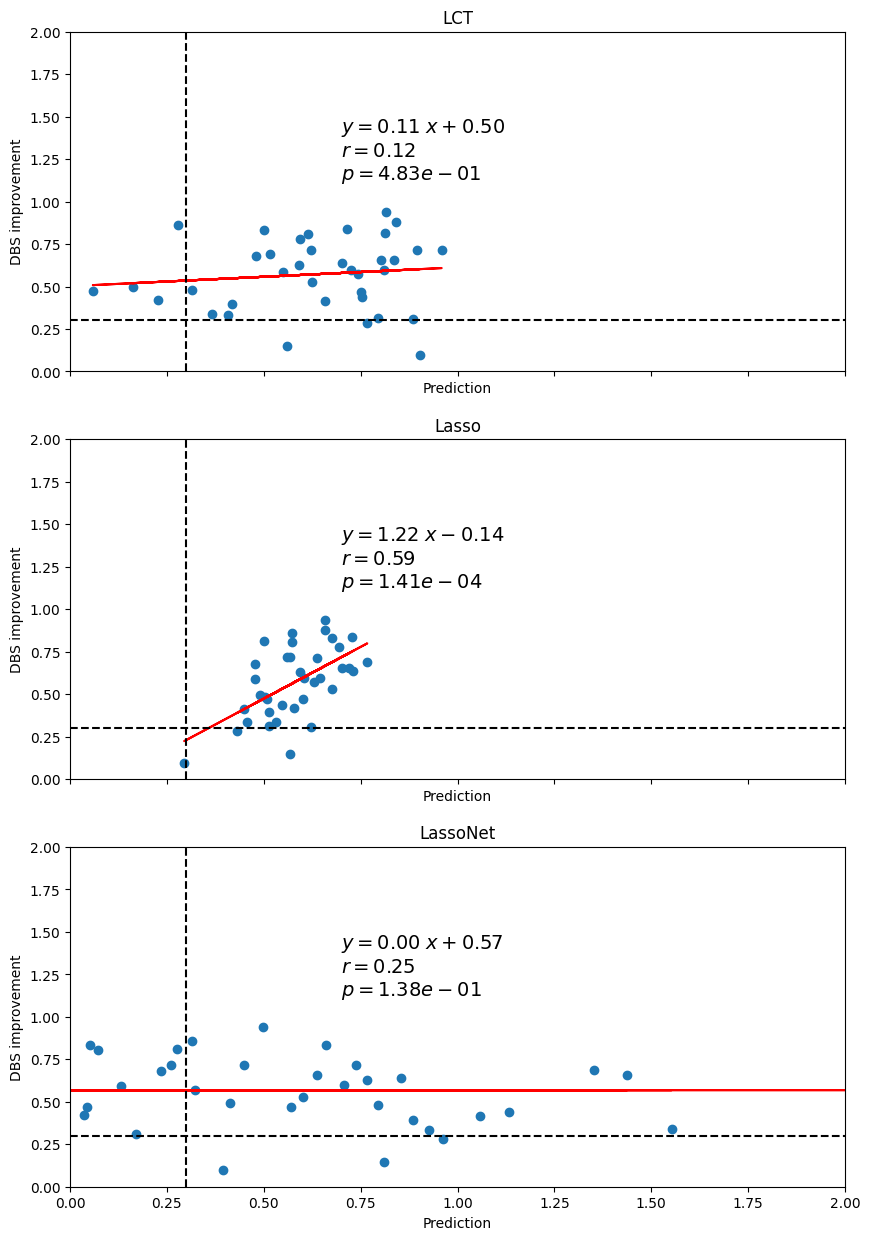

In [4]:
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               results_bls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                'LassoNet'
                                ],(30,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')



Text(0.1, 0.8, '$y=0.00\\; x+0.57$\n$r = 0.25$\n$p = 1.38e-01$')

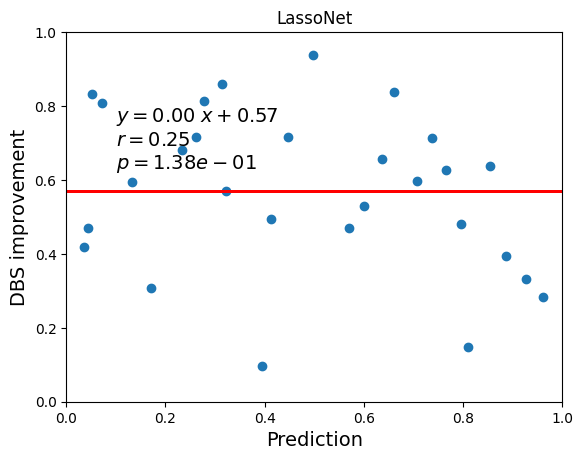

In [5]:
plt.scatter(results_bls,per_change)
lr = stats.linregress(results_bls,per_change)
plt.plot(results_bls,results_bls*lr.slope+lr.intercept,color='r')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('LassoNet')
plt.ylabel("DBS improvement",fontsize=14)
plt.xlabel("Prediction",fontsize=14)
text = f"$y={lr.slope:0.2f}\; x{lr.intercept:+0.2f}$\n$r = {lr.rvalue:0.2f}$\n$p = {lr.pvalue:0.2e}$"
plt.text(0.1, 0.8, text,
    fontsize=14, verticalalignment='top')

Text(0.1, 0.8, '$y=0.00\\; x+0.57$\n$r = 0.25$\n$p = 1.38e-01$')

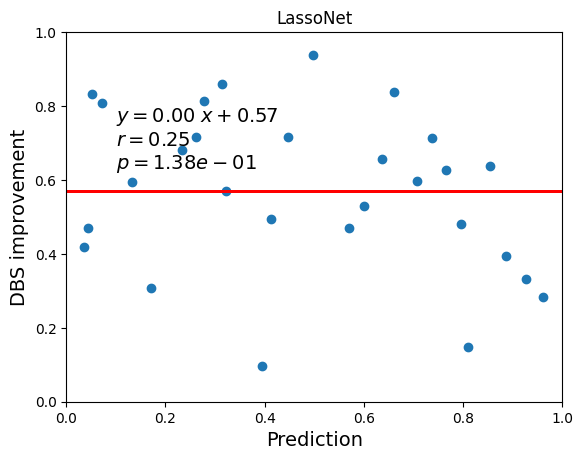

In [6]:
plt.scatter(results_bls,per_change)
lr = stats.linregress(results_bls,per_change)
plt.plot(results_bls,results_bls*lr.slope+lr.intercept,color='r')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('LassoNet')
plt.ylabel("DBS improvement",fontsize=14)
plt.xlabel("Prediction",fontsize=14)
text = f"$y={lr.slope:0.2f}\; x{lr.intercept:+0.2f}$\n$r = {lr.rvalue:0.2f}$\n$p = {lr.pvalue:0.2e}$"
plt.text(0.1, 0.8, text,
    fontsize=14, verticalalignment='top')